In [1]:
""""
Ceci est le chargement des modules necessaires
"""
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pylab

In [2]:
def read_dataset(fichier):
    """
    La focntion reçoit un fichier text et retourne un dataset
    de type pandas.
    """
    with open(fichier, encoding="utf-8") as fic_op:
        read_line = fic_op.readlines()
        nobs = len(read_line)
        ncols = len(read_line[1].split())
        dic = {}
        for j in range(ncols):
            col = []
            for i in range(nobs):
                obs = read_line[i].split()
                col.append(obs[j])
            if j != ncols-1:
                dic[col[0]] = [float(x) for x in col[1:]]
            else:
                dic[col[0]] = col[1:]
    return pd.DataFrame(dic)


def cholesky(matrix):
    """
    Cette fonction prenant en entrée une matrice symetrique définie positive
    retourne une matrice triangulaire inférieur. C'est la methode de Cholesky
    """
    matrix = np.array(matrix)
    chol = np.zeros(matrix.shape)
    for j in range(matrix.shape[0]):
        for i in range(j, matrix.shape[0]):
            if i == j:
                chol[i, j] = np.sqrt(matrix[i, j] - np.sum(chol[i, :j]**2))
            else:
                chol[i, j] = (matrix[i, j] - np.sum(chol[i, :j]*chol[j, :j]))/chol[j, j]
    return chol


def solve_line_sys(chol, tary):
    """
    La fonction prend en entrée une matrice triangulaire inférieur et une matrice ligne.
    Le principe est de faire une resolution d'un système linéaire A*B=targy et le but
    est de trouver les valeurs de B.
    """
    chol = np.array(chol)
    tary = np.array(tary)
    tmatrix = chol.transpose()
    nline = chol.shape[0]
    soly = np.zeros(nline)
    solx = np.zeros(nline)
    for i in range(nline):
        sumj = 0
        for j in range(i):
            sumj += chol[i, j]*soly[j]
        soly[i] = (tary[i]-sumj)/chol[i, i]
    for i in sorted(range(nline), reverse=True):
        sumj = 0
        for j in range(i+1, nline):
            sumj += tmatrix[i, j]*solx[j]
        solx[i] = (soly[i]-sumj)/tmatrix[i, i]
    return solx.reshape((solx.shape[0], 1))


def matrix_dot(matrixa, matrixb):
    """
    La fonction prend en entrée deux matrice et de faire la multiplication
    """
    matrixa = np.array(matrixa)
    matrixb = np.array(matrixb)
    matrixc = np.zeros((matrixa.shape[0], matrixb.shape[1]))
    if matrixa.shape[1] == matrixb.shape[0]:
        for i in range(matrixa.shape[0]):
            for j in range(matrixb.shape[1]):
                for mrg in range(matrixa.shape[1]):
                    matrixc[i, j] = matrixc[i, j] + matrixa[i, mrg] * matrixb[mrg, j]
    return matrixc

def matrix_transp(matrix):
    """
    La fonction prend en entrée une matrice et de retourner sa transposée.
    """
    matrix = np.array(matrix)
    matrixa = np.zeros((matrix.shape[1], matrix.shape[0]))
    for i in range(matrixa.shape[0]):
        for j in range(matrixa.shape[1]):
            matrixa[i, j] = matrix[j, i]
    return matrixa



class OrdinaryLeastSquares:
    """ la classe permet d'estimer les coefficients du modele
    en utilisant la methode des moindres carres"""
    def __init__(self, intercept=True):
        self.intercept = intercept
        self.coeff = {}
        self.beta = np.array([])



    def transp(self, predictor):
        """ la focntion permet juste de multiplier la transpose de la matrice avec
         la matrice elle meme"""
        predictor1 = predictor.copy()
        if self.intercept is True:
            predictor1.insert(0, 'Const', list(np.ones(predictor.shape[0])))
            txx = matrix_dot(matrix_transp(np.array(predictor1)), np.array(predictor1))
        else :
            txx = matrix_dot(matrix_transp(np.array(predictor1)), np.array(predictor1))
        return txx


    def fit(self, predictor, target):
        """ la fonction permet d'estimer les coefficients"""
        predictor1 = predictor.copy()
        target = np.array(target).reshape((target.shape[0],1))
        if self.intercept is True:
            predictor1.insert(0, 'Const', list(np.ones(predictor.shape[0])))
            chol = cholesky(self.transp(predictor))
            txy = matrix_dot(matrix_transp(predictor1), target)
            self.beta = solve_line_sys(chol, txy)
        else:
            chol = cholesky(self.transp(predictor1))
            txy = matrix_dot(matrix_transp(predictor1), target)
            self.beta = solve_line_sys(chol, txy)
        for i in range(self.beta.shape[0]):
            self.coeff[predictor1.columns[i]] = self.beta[i, 0]


    def predict(self, predictor):
        """La fonction permet de donner la valeur du target en prenant
        comme entre les predicteurs """
        predictor1 = predictor.copy()
        if self.intercept is True:
            predictor1.insert(0, 'Const', list(np.ones(predictor.shape[0])))
            predic = matrix_dot(predictor1, self.beta)
        else:
            predic = matrix_dot(predictor1, self.beta)
        return predic


    def get_coeffs(self):
        """
        La fonction permet de  retourner les coefficients estimees
        avec leur coefficients associees
        """
        return self.coeff

class LinearModel(OrdinaryLeastSquares):
    """ C'est la classe de la regression Lineaire """
    def __init__(self, intercept):
        self.residuals = float()
        self.rsquare = float()
        self.rank = float()
        self.name = 'Linear Regression Model'
        super().__init__(intercept)


    def summary(self, predictor, target):
        """
        Cette fonction retourne un resumé des resultats de la regression lineaire
        """
        predictor1 = predictor.copy()
        target = np.array(target).reshape((target.shape[0], 1))
        targbar = np.mean(target)*np.ones((target.shape[0], 1))
        if self.intercept is True:
            matix = super().transp(predictor)
            self.residuals = target - super().predict(predictor)
            sct = sum((target-targbar)**2)[0]
            self.rank = np.linalg.matrix_rank(matix)
        else:
            self.residuals = target - super().predict(predictor)
            sct = sum(target**2)[0]
            matix = super().transp(predictor)
        inver = np.linalg.inv(matix)
        self.rank = np.linalg.matrix_rank(matix)
        scr = sum(self.residuals**2)[0]
        self.rsquare = (1 - scr/sct)
        nobs = np.array(predictor).shape[0]
        sigma = scr/(nobs-self.rank)
        std = []
        tstud = []
        pval = []
        borinf = []
        borsup = []
        for i in range(self.rank):
            std.append(np.sqrt(sigma*inver[i, i]))
            tstud.append(self.beta[i, 0]/std[i])
            pval.append(stats.t.sf(np.abs(tstud[i]), nobs - self.rank)*2)
            borinf.append(self.beta[i, 0] - stats.t.ppf(0.975, nobs - self.rank) * std[i])
            borsup.append(self.beta[i, 0] + stats.t.ppf(0.975, nobs - self.rank) * std[i])
        dic = {}
        dic["Estimate"] = list(self.beta.reshape(self.rank,))
        dic["Std err"] = std
        dic["t"] = tstud
        dic["P>|t|"] = pval
        dic["BorneInf"] = borinf
        dic["BorneSup"] = borsup
        if self.intercept is True:
            predictor1.insert(0, 'Const', list(np.ones(predictor.shape[0])))
            fsta = ((nobs-self.rank)/(self.rank - 1))*(self.rsquare/(1 - self.rsquare))
            pvalf = 1 - stats.f.cdf(fsta, self.rank-1, nobs-self.rank)
            raj = 1 - ((nobs-1)/(nobs-self.rank))*(1 - self.rsquare)
        else:
            raj = 1 - (nobs/(nobs-self.rank))*(1-self.rsquare)
        data = pd.DataFrame(dic, index=predictor1.columns)
        print(" "*37, self.name)
        print("*"*90)
        print("Residuals: ")
        dics= {}
        sre = lambda i: np.round(np.quantile(self.residuals,
                                             np.array([0, 0.25, 0.5, 0.75, 1]))[i], 2)
        dics["Min"] = sre(0)
        dics[" "*8] = " "
        dics["1Q"] = sre(1)
        dics[" "*7] = " "
        dics["Median"]  = sre(2)
        dics[" "*6] = " "
        dics["3Q"] = sre(3)
        dics[" "*5] = " "
        dics["Max"] = sre(4)
        print(pd.DataFrame([dics]).set_index("Min"))
        print("*"*90)
        print("Coefficients: ")
        print(data)
        print("*"*90)
        print("Residual Std err:", f"{round(np.sqrt(sigma), 4)}",
              " avec ", f'{nobs-self.rank}', " degré de liberté")
        print("R_square: ", f'{round(self.rsquare, 4)}',
              " "*10, 'Adj. R_square :', f"{round(raj, 4)}")
        if self.intercept is True:
            print("F-statistic :", f'{round(fsta,4)}', " avec", f"{self.rank-1}",
                  "et", f"{nobs-self.rank}", "DF", "p_valeur:", f'{pvalf}')
        print("*"*90)


    def determination_coefficient(self):
        """
        cette fonction permet de retourner le coefficient
        de determination du modele
        """
        return self.rsquare


    def graphe_residus(self):
        """
        Cette fonction permet d'afficher le graphe des résidus et à
        coté  le graphe qqpot qui permet d'observer l'adéquation des
        residus avec la normale.
        """
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.distplot(self.residuals, color='orange')
        plt.title('Distribution des résidus')
        plt.subplot(1, 2, 2)
        stats.probplot(self.residuals[:, 0], dist="norm", plot=pylab)
        pylab.show()
        plt.show()


class Ridge(LinearModel):
    """
    C'est la classe du modele Ridge.
    """
    def __init__(self, intercept, lambada):
        super().__init__(intercept)
        self.lambada = lambada
        self.name = "Ridge Model"


    def transp(self, predictor):
        """
        Cette fonction permet de mettre en jour la classe OLS en presence
        de la valeur lambda
        """
        return super().transp(predictor) + self.lambada * np.eye(super().transp(predictor).shape[0])


In [3]:
def transform_sampling(qantile, lambada, nobs):
    """
    La fonction permet de simuler des variables aleatoires avec
    la methode d'inverse de la fonction repartition
    """
    varx = np.zeros(nobs)
    for i in range(nobs):
        varx[i] = qantile(np.random.uniform(0, 1, 1), lambada)
    return varx


def centrales_limites(sets, size_n, nsim, mux, sigma):
    """
    La fonction retourne des variables aleatoires simulées avec
    la methode du central limite
    """
    varz = np.zeros(nsim)
    for i in range(nsim):
        varx = np.random.choice(sets, size=size_n, replace=False)
        varz[i] = np.sqrt(size_n)*(np.mean(varx) - mux)/sigma
    return varz


### Jeux de données

In [5]:
dataset = read_dataset('fuel2001.txt')
X = dataset[["Income", "Miles", "Tax", "MPC"]]
X["Dlic"] = 1000 * dataset.Drivers / dataset.Pop
y = 1000 * dataset.FuelC / dataset.Pop

C:\Users\Ba Souleymane\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Affichage de LinearModel

In [6]:
mod = LinearModel(intercept=True)
mod.fit(X, y)

In [7]:
mod.summary(X, y)

                                      Linear Regression Model
******************************************************************************************
Residuals: 
                     1Q          Median            3Q          Max
Min                                                               
-102.99          -31.59            2.47         25.19        97.05
******************************************************************************************
Coefficients: 
          Estimate     Std err         t         P>|t|    BorneInf    BorneSup
Const   103.804295  120.991159  0.857949  3.954671e-01 -139.884407  347.492997
Income   -0.000073    0.001814 -0.040490  9.678818e-01   -0.003728    0.003581
Miles     0.000345    0.000130  2.662172  1.072880e-02    0.000084    0.000606
Tax      -1.943743    1.486963 -1.307190  1.977883e-01   -4.938640    1.051154
MPC       0.031563    0.004403  7.168546  5.734565e-09    0.022695    0.040431
Dlic      0.214783    0.104871  2.048069  4.641499e-02

In [11]:
mod.get_coeffs()

{'Const': 103.80429466814711,
 'Income': -7.346554907419174e-05,
 'Miles': 0.0003450499285718293,
 'Tax': -1.943743344988325,
 'MPC': 0.0315629726721714,
 'Dlic': 0.21478347845911272}

In [13]:
mod.determination_coefficient()

0.7551477356878742

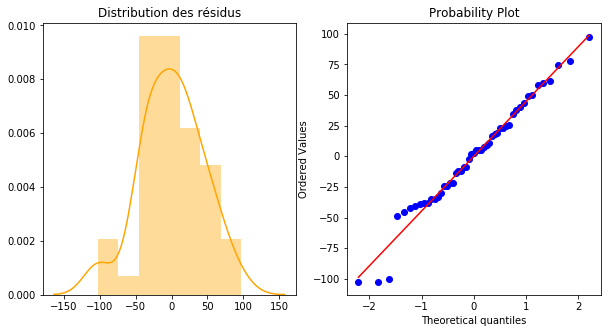

In [16]:
mod.graphe_residus()

### Affichage de Ridge

In [19]:
mod2 = Ridge(intercept=True, lambada=50)
mod2.fit(X, y)

In [22]:
mod2.summary(X,y)

                                      Ridge Model
******************************************************************************************
Residuals: 
                     1Q          Median            3Q         Max
Min                                                              
-114.63          -29.08           -0.23         28.06        91.7
******************************************************************************************
Coefficients: 
        Estimate     Std err         t         P>|t|    BorneInf    BorneSup
Const   0.297841  121.973604  0.002442  9.980625e-01 -245.369607  245.965289
Income  0.000888    0.001829  0.485303  6.298159e-01   -0.002796    0.004572
Miles   0.000381    0.000131  2.915362  5.520451e-03    0.000118    0.000644
Tax    -1.374372    1.499037 -0.916837  3.641159e-01   -4.393588    1.644843
MPC     0.032797    0.004439  7.388805  2.711031e-09    0.023857    0.041737
Dlic    0.268749    0.105723  2.542014  1.453442e-02    0.055812    0.481685
****

In [23]:
mod2.get_coeffs()

{'Const': 0.29784079458872703,
 'Income': 0.0008876955714701685,
 'Miles': 0.0003809346994972142,
 'Tax': -1.3743722135869345,
 'MPC': 0.03279693423666394,
 'Dlic': 0.2687487074702645}

In [25]:
mod2.determination_coefficient()

0.7511552032105722

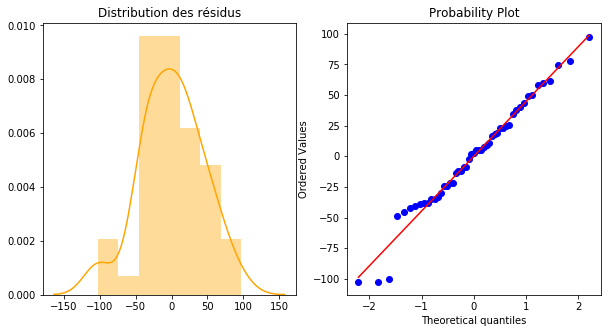

In [27]:
mod.graphe_residus()

## Simulation 

#### Simulation des variables de la loi exponentielle

In [28]:
qantiexp = lambda u, lambada: -np.log(1-u)/lambada
sample1 = transform_sampling(qantiexp, 1, 10000)
abscisse1 = np.linspace(0, 10)

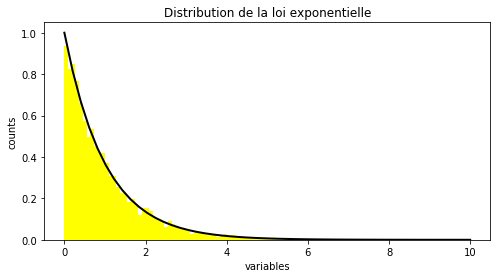

In [30]:
plt.figure(figsize=(8, 4))
plt.hist(sample1, bins=100, color="yellow", density=True)
plt.plot(abscisse1, stats.expon.pdf(abscisse1, loc=0, scale=1), color="black", lw=2)
plt.title("Distribution de la loi exponentielle")
plt.xlabel("variables")
plt.ylabel("counts")
plt.show()

#### Simulation des variables aléatoires de la loi normale standard avec la méthode centrale limite

In [32]:
tcl_z2 = centrales_limites(np.random.uniform(0, 1, 100000),
                           size_n=100, nsim=2000, mux=0.5, sigma=np.sqrt(1/12))
tcl_z1 = centrales_limites(np.random.poisson(5, 100000),
                           size_n=100, nsim=2000, mux =5, sigma=np.sqrt(5))
abscisse = np.linspace(-10, 10)

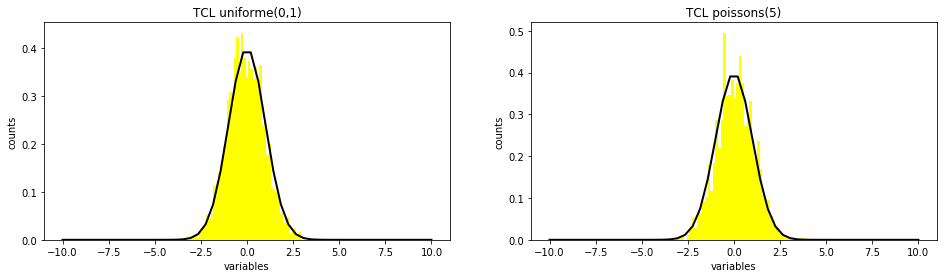

In [33]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.hist(tcl_z2, bins=50, color="yellow", density=True)
plt.plot(abscisse, stats.norm.pdf(abscisse, loc=0, scale=1), color="black", lw=2)
plt.title("TCL uniforme(0,1)")
plt.xlabel("variables")
plt.ylabel("counts")
plt.subplot(1, 2, 2)
plt.hist(tcl_z1, bins=50, color="yellow", density=True)
plt.plot(abscisse, stats.norm.pdf(abscisse, loc=0, scale=1), color="black", lw=2)
plt.title("TCL poissons(5)")
plt.xlabel("variables")
plt.ylabel("counts")
plt.show()
